# Solving a Driven, Damped Harmonic Oscillator with `SciPy`

Last week, we solved some differential equations with custom Euler and Runge-Kutta codes. `Scipy` can solve *initial value problems* like this with built-in functions. This week, we will explore the damped, driven harmonic oscillator with these built-in functions.

Here is the equation we want to solve:

$$ m \ddot{Q} + 2 \gamma m \dot{Q} + k Q = F_0 \sin(\omega t + \phi) $$

Notice that this is the same as the equation of motion we derived for any push away from equilibrium in a harmonic system, except for the term $2 \gamma m \dot(Q)$ which we can view as a *damping term*. This allows our oscillator to slowly dissipate energy.

We'll focus on:
1. Visualizing the displacement $Q(t)$, velocity $V(t)$, and driving force $F_0 \sin(\omega t + \phi)$.
2. Plotting the phase portrait (displacement vs. velocity).
3. Computing and plotting the kinetic, potential, and total energy.


In [27]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import ipywidgets as widgets

## Defining first-order equations

Last week we learned that we can solve differential equations like this by setting up a system of first-order equations and numerically approximating the trajectory. To do this, we need to relate the first derivative of `Q` in time, to its velocity. That is, $ \dot{Q} = V $.

This takes the equation of motion and reexpresses it as:
$$ \dot{Q} = V $$
$$ \dot{V} =  \left[ F_0 \sin(\omega t + \phi) - 2 \gamma m V - k Q \right] / m $$

We will:
- Define the system of first-order ODEs from the second-order equation.
- Assign initial conditions and parameters for mass, damping, spring constant, and the driving force.


In [28]:
# Define the system of first-order ODEs
def harmonic_oscillator(t, y, m, gamma, k, F0, omega, phi):
    Q, V = y
    dQdt = V
    dVdt = (F0 * np.sin(omega * t + phi) - 2 * gamma * m * V - k * Q) / m
    return [dQdt, dVdt]


In [29]:
def analytic_sol(t, A, y, w0, N):
    wy = np.sqrt((w0 ** 2) - (y ** 2))
    return (A * np.exp(-y * t) * np.cos(wy * t)) + (N * np.exp(-y * t) * np.sin(wy * t))

## Defining initial conditions and parameters

We want to define some parameters to get things started. We will need to set some initial conditions as well. (We can always put everything into an interactive environment once things are working.)

In [30]:
# Define parameters
m = 1.0  # mass
gamma = 0.1  # damping coefficient
k = 1.0  # spring constant
F0 = 1.0  # amplitude of the driving force
omega = 1.0  # angular frequency of the driving force
phi = 0.0  # phase of the driving force

# Initial conditions for Q and V
Q0 = 0.0  # initial displacement
V0 = 0.0  # initial velocity
y0 = [Q0, V0]

# Time span for the solution
t_span = (0, 50)  # start and end time
t_eval = np.linspace(0, 50, 1000)  # times at which to store the computed solution

## `solve_ivp` syntax

First, take a look at the help file for `solve_ivp`.

In [31]:
help(solve_ivp)

Help on function solve_ivp in module scipy.integrate._ivp.ivp:

solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options)
    Solve an initial value problem for a system of ODEs.

    This function numerically integrates a system of ordinary differential
    equations given an initial value::

        dy / dt = f(t, y)
        y(t0) = y0

    Here t is a 1-D independent variable (time), y(t) is an
    N-D vector-valued function (state), and an N-D
    vector-valued function f(t, y) determines the differential equations.
    The goal is to find y(t) approximately satisfying the differential
    equations, given an initial value y(t0)=y0.

    Some of the solvers support integration in the complex domain, but note
    that for stiff ODE solvers, the right-hand side must be
    complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
    To solve a problem in the complex domain, pass y0 with a complex data type.

## Testing the output

In [32]:
# solve ivp
sol = solve_ivp(harmonic_oscillator, # differential equation to be solved
                [0, 50], # time interval
                y0, # initial conditions
                method='RK45', # method to be used. here it is Runge-Kutta 45, the default. (4th order with 5th order error estimate)
                t_eval=np.linspace(0, 50, 1000), # explicit points to evaluate the solution on, if desired
                args=(m, gamma, k, F0, omega, phi)) # arguments which are passed to `harmonic_oscillator`
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.005e-02 ...  4.995e+01  5.000e+01]
        y: [[ 0.000e+00  2.084e-05 ... -4.725e+00 -4.795e+00]
            [ 0.000e+00  1.248e-03 ... -1.520e+00 -1.282e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 362
     njev: 0
      nlu: 0

You can explore the ***Returns*** portion of the help file for `solve_ivp` to better understand the output.

For basic usage, `t`, and `y` are what is needed. 

* `t` is the list of times for which you have a solution.
* `y` is a list of solutions. `y[0]` will be the first solution, `y[1]` the second, etc.
    * In our case, `y[0]` is `Q(t)` and `y[1]` is `V(t)`

In [33]:
np.transpose([sol.t[0:10],sol.y[0][0:10],sol.y[1][0:10]])

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00500501e-02, 2.08352092e-05, 1.24781467e-03],
       [1.00100100e-01, 1.66168003e-04, 4.96843568e-03],
       [1.50150150e-01, 5.58536348e-04, 1.11186762e-02],
       [2.00200200e-01, 1.31836393e-03, 1.96433464e-02],
       [2.50250250e-01, 2.56324125e-03, 3.04757093e-02],
       [3.00300300e-01, 4.40655392e-03, 4.35381163e-02],
       [3.50350350e-01, 6.95745397e-03, 5.87420196e-02],
       [4.00400400e-01, 1.03203451e-02, 7.59884483e-02],
       [4.50450450e-01, 1.45942933e-02, 9.51686482e-02]])

We can plot them to see that everything is in order.

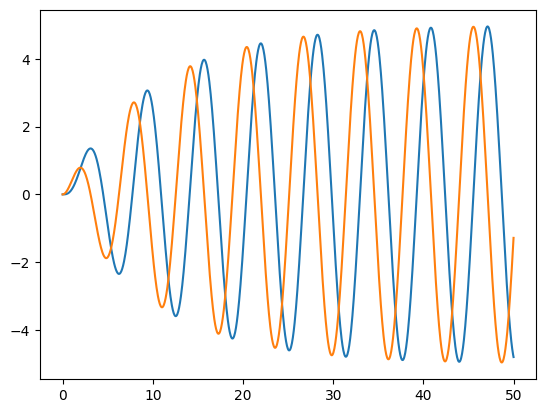

In [34]:
plt.plot(sol.t,sol.y[0])
plt.plot(sol.t,sol.y[1])
plt.show()

## Exploring the solution

Now that we know things are working, let's plot the solutions and explore the behavior with interactive sliders.

In [40]:
# Update the plotting function to include energy plots and numerical integration
def solve_ivp_plot(F0, omega, gamma, t_max, Q0, V0):
    # define initial values of Q and V
    y0 = [Q0, V0]
    
    # Solve the system of ODEs
    sol = solve_ivp(harmonic_oscillator, [0, t_max], y0, t_eval=np.linspace(0, t_max, 1000), args=(m, gamma, k, F0, omega, phi))
    Q_sol = sol.y[0]
    V_sol = sol.y[1]
    t_sol = sol.t

    F_drive = F0 * np.sin(omega * t_sol + phi)
    
    true_solution = analytic_sol(t_sol, Q0, phi, np.sqrt(k / m), V0)
    
    # plot Q, V, and F
    plt.figure(figsize=(11,4))
    # Time plot: Displacement, Velocity, and Driving Force
    plt.plot(t_sol, Q_sol, label="Displacement Q(t)")
    plt.plot(t_sol, V_sol, label="Velocity V(t)")
    plt.plot(t_sol, F_drive, label="Driving Force F(t)",color='black')
    plt.plot(t_sol, true_solution, label="True Solution", linestyle="dashdot")
    plt.xlabel("Time [a.u.]")
    plt.ylabel("Amplitude of Q / V / F in a.u.")
    plt.legend()
    plt.show()

# Create sliders for interactive plotting, including a time slider
F0_slider = widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description='F0')
omega_slider = widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description='omega')
gamma_slider = widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='gamma')
t_max_slider = widgets.FloatSlider(value=50, min=10, max=100, step=1, description='Max Time')
Q0_slider = widgets.FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Initial Q_0')
V0_slider = widgets.FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Initial V_0')

# Create the interactive widget
interactive_plot = widgets.interactive(solve_ivp_plot, F0=F0_slider, omega=omega_slider, gamma=gamma_slider, 
                                       t_max=t_max_slider, Q0=Q0_slider, V0=V0_slider)
display(interactive_plot)


interactive(children=(FloatSlider(value=1.0, description='F0', max=5.0), FloatSlider(value=1.0, description='o…

## We can also look at phase space


In [36]:
# Update the plotting function to include energy plots and numerical integration
def solve_ivp_phase(F0, omega, gamma, t_max, Q0, V0):
    # define initial values of Q and V
    y0 = [Q0, V0]
    
    # Solve the system of ODEs
    sol = solve_ivp(harmonic_oscillator, [0, t_max], y0, t_eval=np.linspace(0, t_max, 1000), args=(m, gamma, k, F0, omega, phi))
    Q_sol = sol.y[0]
    V_sol = sol.y[1]
    t_sol = sol.t

    # plot
    plt.figure(figsize=(6,6))    
    # Phase plot: Displacement vs Velocity
    plt.plot(Q_sol, V_sol, label="Q vs V")
    plt.xlabel("Displacement Q(t)")
    plt.ylabel("Velocity V(t)")

# Create sliders for interactive plotting, including a time slider
F0_slider = widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description='F0')
omega_slider = widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description='omega')
gamma_slider = widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='gamma')
t_max_slider = widgets.FloatSlider(value=50, min=10, max=100, step=1, description='Max Time')
Q0_slider = widgets.FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Initial Q_0')
V0_slider = widgets.FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Initial V_0')

# Create the interactive widget
interactive_plot = widgets.interactive(solve_ivp_phase, F0=F0_slider, omega=omega_slider, gamma=gamma_slider, 
                                       t_max=t_max_slider, Q0=Q0_slider, V0=V0_slider)
display(interactive_plot)


interactive(children=(FloatSlider(value=1.0, description='F0', max=5.0), FloatSlider(value=1.0, description='o…

## ...energy


In [37]:
# Update the plotting function to include energy plots and numerical integration
def solve_ivp_energy(F0, omega, gamma, t_max, Q0, V0):
    # define initial values of Q and V
    y0 = [Q0, V0]

    # Solve the system of ODEs
    sol = solve_ivp(harmonic_oscillator, [0, t_max], y0, t_eval=np.linspace(0, t_max, 1000), args=(m, gamma, k, F0, omega, phi))
    Q_sol = sol.y[0]
    V_sol = sol.y[1]
    t_sol = sol.t
        
    # Compute kinetic, potential, and total energy
    kinetic_energy = 0.5 * m * V_sol**2
    potential_energy = 0.5 * k * Q_sol**2
    total_energy = kinetic_energy + potential_energy
        
    # Energy plot
    plt.plot(t_sol, kinetic_energy, label="Kinetic Energy E_k(t)")
    plt.plot(t_sol, potential_energy, label="Potential Energy E_p(t)")
    plt.plot(t_sol, total_energy, label="Total Energy E_total(t)")
    plt.xlabel("Time [a.u.]")
    plt.ylabel("Energy [a.u]")
    plt.legend()
    plt.show()

# Create sliders for interactive plotting, including a time slider
F0_slider = widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description='F0')
omega_slider = widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description='omega')
gamma_slider = widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='gamma')
t_max_slider = widgets.FloatSlider(value=50, min=10, max=100, step=1, description='Max Time')
Q0_slider = widgets.FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Initial Q_0')
V0_slider = widgets.FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Initial V_0')

# Create the interactive widget
interactive_plot = widgets.interactive(solve_ivp_energy, F0=F0_slider, omega=omega_slider, gamma=gamma_slider, 
                                       t_max=t_max_slider, Q0=Q0_slider, V0=V0_slider)
display(interactive_plot)


interactive(children=(FloatSlider(value=1.0, description='F0', max=5.0), FloatSlider(value=1.0, description='o…

## ...and power.

In [38]:
# Update the plotting function to include energy plots and numerical integration
def solve_ivp_power(F0, omega, gamma, t_max, Q0, V0):
    # define initial values of Q and V
    y0 = [Q0, V0]

    # Solve the system of ODEs
    sol = solve_ivp(harmonic_oscillator, [0, t_max], y0, t_eval=np.linspace(0, t_max, 1000), args=(m, gamma, k, F0, omega, phi))
    Q_sol = sol.y[0]
    V_sol = sol.y[1]
    t_sol = sol.t

    # define the driving force
    F_drive = F0 * np.sin(omega * t_sol + phi)

    # define the power
    power = F_drive * V_sol
    
    # Energy plot
    plt.plot(t_sol, power)
    plt.xlabel("Time [a.u.]")
    plt.ylabel("Power [a.u]")
    plt.show()

# Create sliders for interactive plotting, including a time slider
F0_slider = widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description='F0')
omega_slider = widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description='omega')
gamma_slider = widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='gamma')
t_max_slider = widgets.FloatSlider(value=50, min=10, max=100, step=1, description='Max Time')
Q0_slider = widgets.FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Initial Q_0')
V0_slider = widgets.FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Initial V_0')

# Create the interactive widget
interactive_plot = widgets.interactive(solve_ivp_power, F0=F0_slider, omega=omega_slider, gamma=gamma_slider, 
                                       t_max=t_max_slider, Q0=Q0_slider, V0=V0_slider)
display(interactive_plot)


interactive(children=(FloatSlider(value=1.0, description='F0', max=5.0), FloatSlider(value=1.0, description='o…

## Assignment

1. Explore the response of the damped, driven oscillator with the plots above.
2. Add the steady-state analytic solutions derived in class to the plots above.
    * Does the RK45 solver seem to be working correctly?
    * Make sure that the analytic solutions can be visualized concurrently with the numerical results.